### Preliminaries

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 
import pandas as pd
import scipy.io as sio
import os

In [ ]:
%%bash
pip install keras==2.3.1
pip install tensorflow==2.2.0
pip install keras_applications==1.0.8
pip install image-classifiers==1.0.0
pip install efficientnet==1.0.0
pip install keras-unet
pip install tf-semantic-segmentation
pip install segmentation-models

In [6]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


### functions

In [7]:
def plot_t(his_m, mtc='acc', name='none'):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(his_m[mtc][0])
  plt.plot(his_m['val_'+mtc][0])
  plt.title(mtc)
  plt.ylabel(mtc)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(his_m['loss'][0])
  plt.plot(his_m['val_loss'][0])
  plt.title('model loss')
  plt.ylabel('value')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  if not name=='none':
    plt.savefig(name)

In [8]:
def plot_image_mask(ima, mas,  name='none'):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(ima, cmap='inferno')
  plt.title('Image')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(mas, cmap='gray')
  plt.title('Mask')
  plt.axis('off')

  if not name=='none':
    plt.savefig(name)

In [9]:
def three_plot(ori, s_predi, s_real, dice=0, name='none'):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.imshow(ori, cmap='inferno')
  plt.title('MRI Input')
  plt.axis('off') 

  plt.subplot(1,3,2)
  plt.imshow(s_real, cmap='gray')
  plt.title('Ground truth')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(s_predi, cmap='hot')
  plt.title('Prediction')
  plt.axis('off')

  if not name=='none':
    plt.savefig(name)

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

Using TensorFlow backend.


In [11]:
from keras_unet.models import custom_unet
from segmentation_models import Unet, Linknet, FPN, PSPNet

def read_model(net, inputshape=(256,256,3)):
  not_p=True
  if net=='unet_cus':
    model = custom_unet((256,256,3), use_batch_norm=True)
    not_p=False
  
  if net=='multiresunet':
    model=MultiResUnet(256,256,3)
    not_p=False

  if net=='mobileNet':
    model=Unet('mobilenet', inputshape, 1)
    not_p=False

  if net=='unetVgg16':
    model=Unet('vgg16', inputshape, 1)
    not_p=False
  
  if net=='linknet':
    model=Linknet('efficientnetb5', inputshape)
    not_p=False

  if net=='PSPNet':
    model=PSPNet('efficientnetb5',(480,480,3),1)
    not_p=False

  if net=='densenet201':
    model=Unet('densenet201',inputshape,1)
    not_p=False

  if net=='inceptionresnetv2':
    model=Unet('inceptionresnetv2',inputshape,1)
    not_p=False 

  if net=='FPN':
    model=FPN('vgg16',inputshape,1)
    not_p=False

  if not_p:
    print('Network name does not exist')

  return model

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Segmentation Models: using `tf.keras` framework.


### tumor images

In [35]:
PATH='/content/drive/MyDrive/INDIGO_MLR/TumoresCerebrales/'
pathw=PATH+'Weights/'
figures=PATH+'Figures/'

In [ ]:
mats=glob.glob(PATH+'*0.mat')
print(np.shape(mats))

(1,)


In [ ]:
images=[]
masks=[]
labels=[]

for n, i in enumerate(mats):
  data=sio.loadmat(i)
  n_sub,rows,cols=np.shape(data['images'])
  labels=np.append(labels,data['labels'][0])
  ima=np.array(data['images'], np.dtype('float32')).reshape((n_sub,rows,cols,1))
  mks=np.array(data['masks'], np.dtype('float32')).reshape((n_sub,rows,cols,1))
  if n==0:   
    images=ima
    masks=mks
  else:
    images=np.concatenate((images,ima))
    masks=np.concatenate((masks,mks))

In [ ]:
tumor_t=1

if tumor_t==0:
  imagest=images
  maskst=masks
else:
  tumor=np.where(labels==tumor_t)[0]
  imagest=images[tumor]
  maskst=masks[tumor]

In [ ]:
d_size=np.shape(imagest)[0]
indx=np.random.choice(d_size, d_size, replace=False)

imagest=np.array(imagest)[indx]
maskst=np.array(maskst)[indx]

In [ ]:
shap=np.shape(imagest)
imagesRGB=np.zeros((shap[0], shap[1], shap[2], 3))
imagesRGB[...,0]=imagesRGB[...,1]=imagesRGB[...,2]=imagest[...,0]
imagest=imagesRGB

In [ ]:
lx=40
x_test=imagesRGB[:lx]
y_test=maskst[:lx]

### Results

In [ ]:
df = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))

In [ ]:
csvs=glob.glob(PATH+'f_*.csv')
print(np.shape(csvs))

(10,)


In [ ]:
for name_c in csvs:
  csv=pd.read_csv(name_c)
  csv=csv.drop(csv.columns[:np.where(csv.columns=='tumor_type')[0][0]], axis=1)  
  df=df.append(csv, ignore_index=True)

In [ ]:
df[["network", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

dice_coef                      ... specificity                    
                      count      mean       std  ...         50%       75%       max
network                                          ...                                
densenet201            18.0  0.897709  0.141499  ...    0.999161  0.999239  0.999599
inceptionresnetv2      15.0  0.919201  0.032654  ...    0.999096  0.999247  0.999615
mobileNet              26.0  0.898769  0.145522  ...    0.999174  0.999303  0.999697
linknet                17.0  0.925818  0.038780  ...    0.998920  0.999193  0.999268
unet_cus               25.0  0.908627  0.016195  ...    0.998869  0.999099  0.999512
unetVgg16              18.0  0.847534  0.147081  ...    0.999268  0.999602  0.999978
multiresunet           22.0  0.727161  0.159004  ...    0.999449  0.999562  0.999667
PSPNet                  1.0  0.018264       NaN  ...    0.000000  0.000000  0.000000

[8 rows x 24 columns]

In [ ]:
df[["loss", "dice_coef", "sensitivity", "specificity"]].groupby("loss").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

dice_coef            ... specificity          
                               count      mean  ...         75%       max
loss                                            ...                      
tversky_loss                    24.0  0.858108  ...    0.999081  0.999349
dice_coef_loss                  31.0  0.857510  ...    0.999232  0.999978
log_cosh_dice_loss              23.0  0.850029  ...    0.999358  0.999781
weighted_cross_entropyloss      28.0  0.895507  ...    0.999568  0.999838
binary_crossentropy             36.0  0.867738  ...    0.999312  0.999615

[5 rows x 24 columns]

In [ ]:
df[["network", "time"]].groupby("network").describe().sort_values(by=[('time',   'max')])

time               ...                          
                  count         mean  ...          75%          max
network                               ...                          
unet_cus           25.0  1115.439297  ...  1119.712134  1143.752236
PSPNet              1.0  1539.906958  ...  1539.906958  1539.906958
densenet201        18.0  2240.071371  ...  2251.862839  2267.446866
unetVgg16          18.0  2351.528951  ...  3075.120790  3100.177791
linknet            17.0  4632.498313  ...  4642.203100  4685.862700
inceptionresnetv2  15.0  3784.249299  ...  4881.660659  5055.197860
multiresunet       22.0  3889.497147  ...  3802.909883  5789.299129
mobileNet          26.0  4130.205854  ...  5945.956583  6049.238006

[8 rows x 8 columns]

In [ ]:
df[["network", "total_parameters"]].groupby("network").max().sort_values(by='total_parameters')

,total_parameters
network,
unet_cus,1945233
PSPNet,4063690
multiresunet,7262504
mobileNet,8336337
unetVgg16,23752273
densenet201,26378577
linknet,33700449
inceptionresnetv2,62061553


In [ ]:
try:
  del model
except:
  print('...')
ind=np.where(df['dice_coef']==np.max(df['dice_coef']))[0][0]
print(df.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(df.iloc[ind]['network'])
model.load_weights(pathw+df.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test)

...
tumor_type                                                           1
run_n                                                                6
network                                                    densenet201
optimizer                                                         Adam
loss                                                      tversky_loss
epochs                                                             100
total_parameters                                              26378577
time                                                           2238.54
augm                                                              none
jaccard_distances                                            0.0019239
acc                                                           0.998058
sensitivity                                                   0.969178
specificity                                                   0.998587
FPR                                                         0.00141311
di

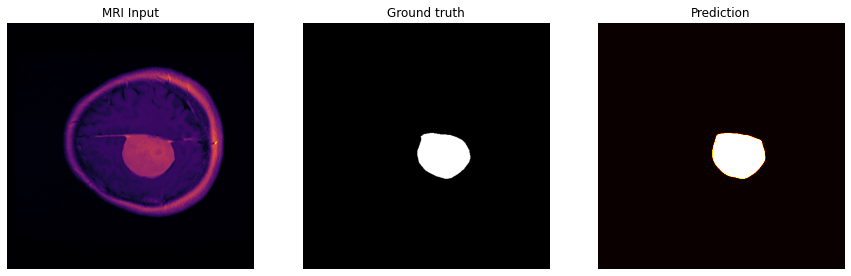

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], dice, figures+'maxi_network_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='inceptionresnetv2']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test)

tumor_type                                                           1
run_n                                                                2
network                                              inceptionresnetv2
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             100
total_parameters                                              62061553
time                                                           2998.98
augm                                                              none
jaccard_distances                                           0.00196655
acc                                                           0.998169
sensitivity                                                    0.93623
specificity                                                   0.999305
FPR                                                        0.000694752
dice_c

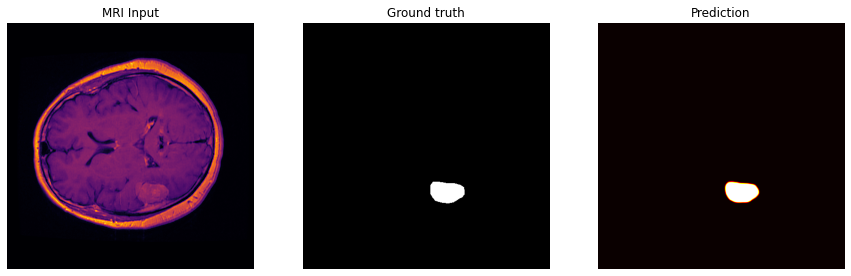

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'inceptionresnetv2_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='mobileNet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test)

tumor_type                                                           1
run_n                                                                1
network                                                      mobileNet
optimizer                                                         Adam
loss                                                log_cosh_dice_loss
epochs                                                             100
total_parameters                                               8336337
time                                                           1490.61
augm                                                              none
jaccard_distances                                           0.00189084
acc                                                           0.998096
sensitivity                                                   0.938773
specificity                                                   0.999113
FPR                                                        0.000886619
dice_c

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


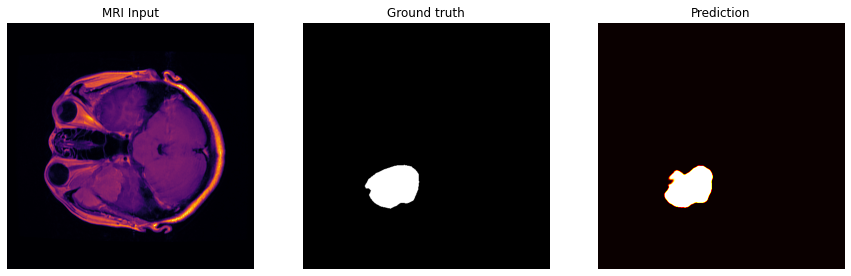

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'mobileNet_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='linknet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test)

tumor_type                                                           1
run_n                                                                0
network                                                        linknet
optimizer                                                         Adam
loss                                                log_cosh_dice_loss
epochs                                                             100
total_parameters                                              33700449
time                                                           4628.98
augm                                                              none
jaccard_distances                                           0.00194784
acc                                                           0.998036
sensitivity                                                   0.946284
specificity                                                    0.99891
FPR                                                         0.00108999
dice_c

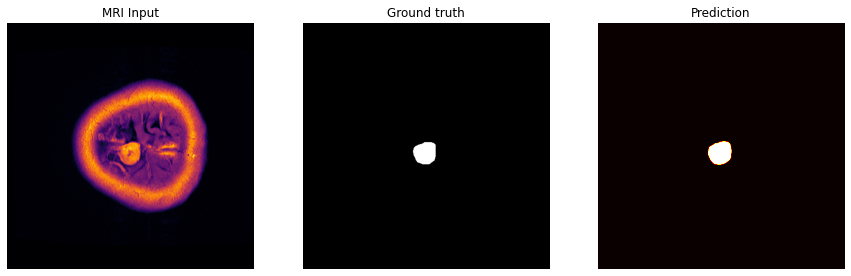

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'linknet_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='unet_cus']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test[...,0])

tumor_type                                                           1
run_n                                                                0
network                                                       unet_cus
optimizer                                                         Adam
loss                                                log_cosh_dice_loss
epochs                                                             100
total_parameters                                               1945233
time                                                           1109.18
augm                                                              none
jaccard_distances                                           0.00254341
acc                                                            0.99744
sensitivity                                                   0.915802
specificity                                                   0.998959
FPR                                                         0.00104094
dice_c

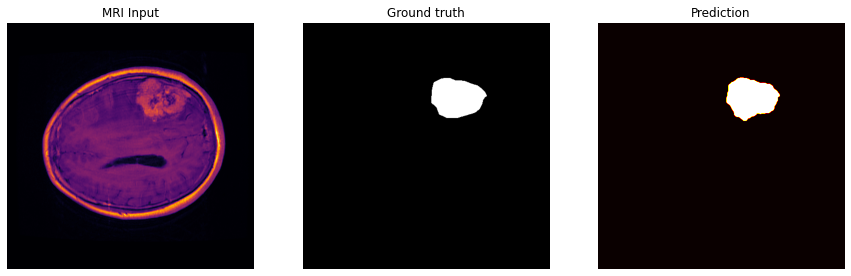

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'unet_cus_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='unetVgg16']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test)

tumor_type                                                           1
run_n                                                                4
network                                                      unetVgg16
optimizer                                                         Adam
loss                                                      tversky_loss
epochs                                                             100
total_parameters                                              23752273
time                                                           1765.14
augm                                                              none
jaccard_distances                                           0.00268679
acc                                                            0.99729
sensitivity                                                   0.925544
specificity                                                   0.998599
FPR                                                         0.00140101
dice_c

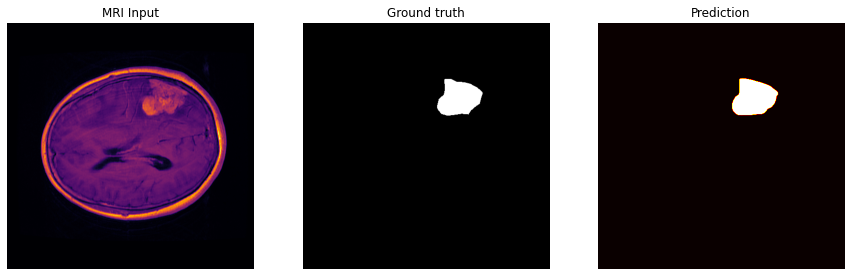

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'unetVgg16_results.svg')

In [ ]:
try:
  del model
except:
  print('...')
dafra=df.loc[df['network']=='multiresunet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=df.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(pathw+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_test[...,0].reshape((lx,512,512,1)))

tumor_type                                                           1
run_n                                                                2
network                                                   multiresunet
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                             100
total_parameters                                               7262504
time                                                           3804.09
augm                                                              none
jaccard_distances                                           0.00690478
acc                                                           0.997866
sensitivity                                                    0.90651
specificity                                                   0.999495
FPR                                                        0.000504673
dice_c

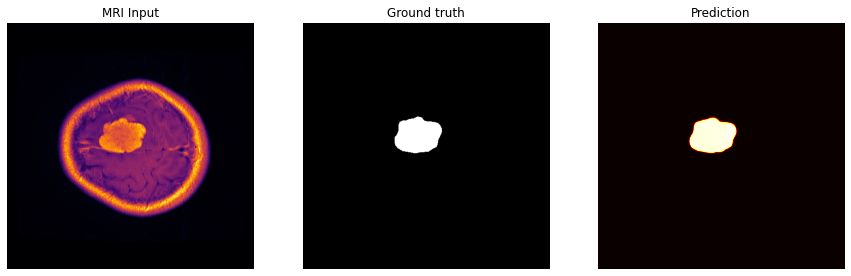

In [ ]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_test[indi,:,:,0], y_hat[indi,:,:,0], y_test[indi,:,:,0], figures+'multiresunet_results.svg')

### Training

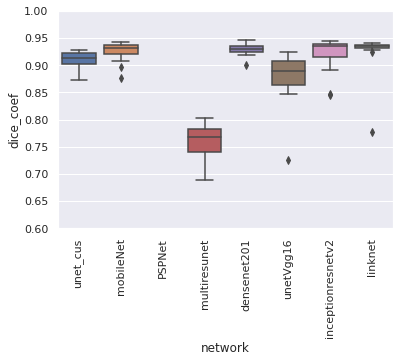

In [ ]:
#sn.swarmplot(x="network", y="dice_coef", data=df)
sn.boxplot(x="network", y="dice_coef", data=df)
sn.set_theme()
plt.ylim((0.6, 1))
plt.xticks(rotation='vertical')
plt.savefig('boxplotNetworks.svg')

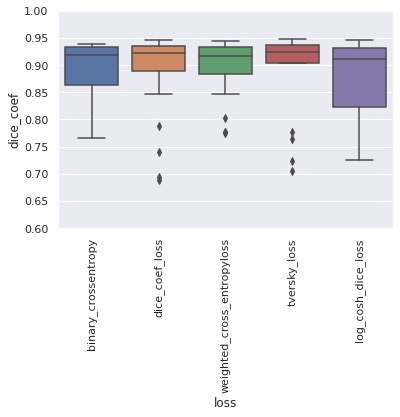

In [ ]:
#sn.swarmplot(x="loss", y="dice_coef", data=df)
sn.boxplot(x="loss", y="dice_coef", data=df)
sn.set_theme()
plt.ylim((0.6, 1))
plt.xticks(rotation='vertical')
plt.savefig('losses.svg')

18


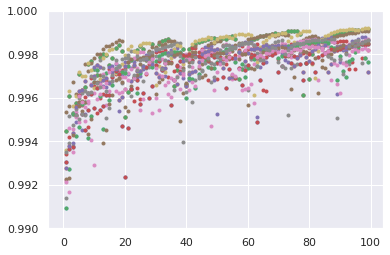

In [ ]:
dfp=df.loc[df['network']=='densenet201']['result_mat']

for i in dfp:
  sx=sio.loadmat(pathw+i)
  plt.plot(sx['acc'][0], '.')
plt.ylim((0.99, 1))
print(np.shape(dfp)[0])

18


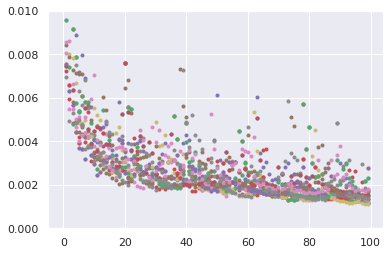

In [ ]:
for i in dfp:
  sx=sio.loadmat(pathw+i)
  plt.plot(sx['jaccard_distance'][0], '.')
plt.ylim((0, 0.010))
print(np.shape(dfp)[0])

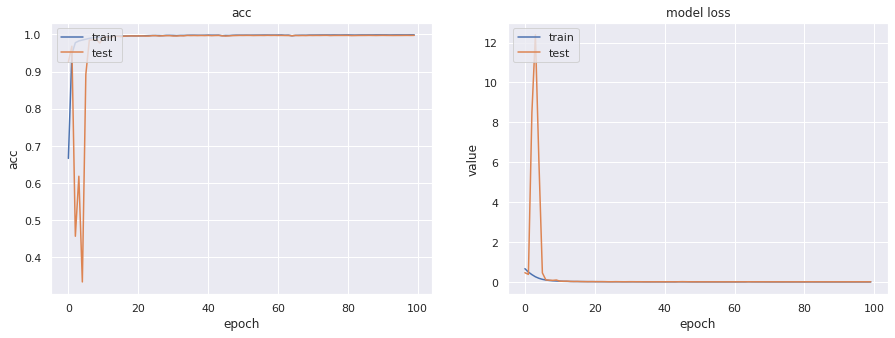

In [ ]:
ind=np.where(df['dice_coef']==np.max(df['dice_coef']))[0][0]
his=sio.loadmat(pathw+df.iloc[0]['result_mat'])
plot_t(his)

### Andres data

In [12]:
dfA = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))

In [13]:
csvs2=glob.glob('/content/drive/MyDrive/TCIA/lgg-mri-segmentation/new_version/res*.csv')
path_a='/content/drive/MyDrive/TCIA/lgg-mri-segmentation/new_version/Weights_n/'
print(np.shape(csvs2))

(1,)


In [14]:
for name_c in csvs2:
  csv=pd.read_csv(name_c)
  csv=csv.drop(csv.columns[:np.where(csv.columns=='tumor_type')[0][0]], axis=1)  
  dfA=dfA.append(csv, ignore_index=True)

In [15]:
dfA[["network", "dice_coef", "sensitivity", "specificity"]].groupby("network").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

dice_coef                      ... specificity                    
                      count      mean       std  ...         50%       75%       max
network                                          ...                                
linknet                 5.0  0.695398  0.389044  ...    0.998960  0.999002  0.999695
inceptionresnetv2       5.0  0.665458  0.374944  ...    0.998561  0.999087  0.999546
mobileNet               5.0  0.659640  0.370981  ...    0.996262  0.998854  0.999630
densenet201             7.0  0.564030  0.389513  ...    0.998744  0.999317  1.000000
unet_cus                5.0  0.637093  0.359608  ...    0.997805  0.998975  0.999372
unetVgg16               5.0  0.434918  0.414514  ...    0.999254  0.999537  1.000000
multiresunet            3.0  0.734307  0.038314  ...    0.998378  0.998958  0.999537

[7 rows x 24 columns]

In [16]:
dfA[["loss", "dice_coef", "sensitivity", "specificity"]].groupby("loss").describe().sort_values(by=[('dice_coef',   'max')], ascending=False)

dice_coef            ... specificity          
                               count      mean  ...         75%       max
loss                                            ...                      
tversky_loss                     6.0  0.666312  ...    0.998612  1.000000
binary_crossentropy              8.0  0.830889  ...    0.999003  0.999254
weighted_cross_entropyloss       7.0  0.833407  ...    0.999647  0.999695
dice_coef_loss                   8.0  0.641794  ...    0.998671  1.000000
log_cosh_dice_loss               6.0  0.000081  ...    0.401931  0.411291

[5 rows x 24 columns]

In [17]:
dfA[["network", "time"]].groupby("network").describe().sort_values(by=[('time',   'max')])

time               ...                          
                  count         mean  ...          75%          max
network                               ...                          
unet_cus            5.0   813.258611  ...  1040.929090  1044.345531
mobileNet           5.0   672.644276  ...   789.712816  1096.999359
unetVgg16           5.0  1771.379592  ...  2447.706221  2454.897074
linknet             5.0  2242.145442  ...  2666.504747  2781.223322
densenet201         7.0  2043.688717  ...  2528.899807  3413.249818
inceptionresnetv2   5.0  2594.005983  ...  3682.725612  3917.295312
multiresunet        3.0  5675.916305  ...  6106.930879  6852.602820

[7 rows x 8 columns]

In [18]:
dfA[["network", "total_parameters"]].groupby("network").max().sort_values(by='total_parameters')

,total_parameters
network,
unet_cus,1945521
multiresunet,7262504
mobileNet,8336337
unetVgg16,23752273
densenet201,26378577
linknet,33700449
inceptionresnetv2,62061553


In [19]:
x_rgb=np.load('/content/drive/MyDrive/TCIA/lgg-mri-segmentation/new_version/ImgData_n/images_array_v2.npy')
y_rgb=np.load('/content/drive/MyDrive/TCIA/lgg-mri-segmentation/new_version/ImgData_n/masks_array_v2.npy')

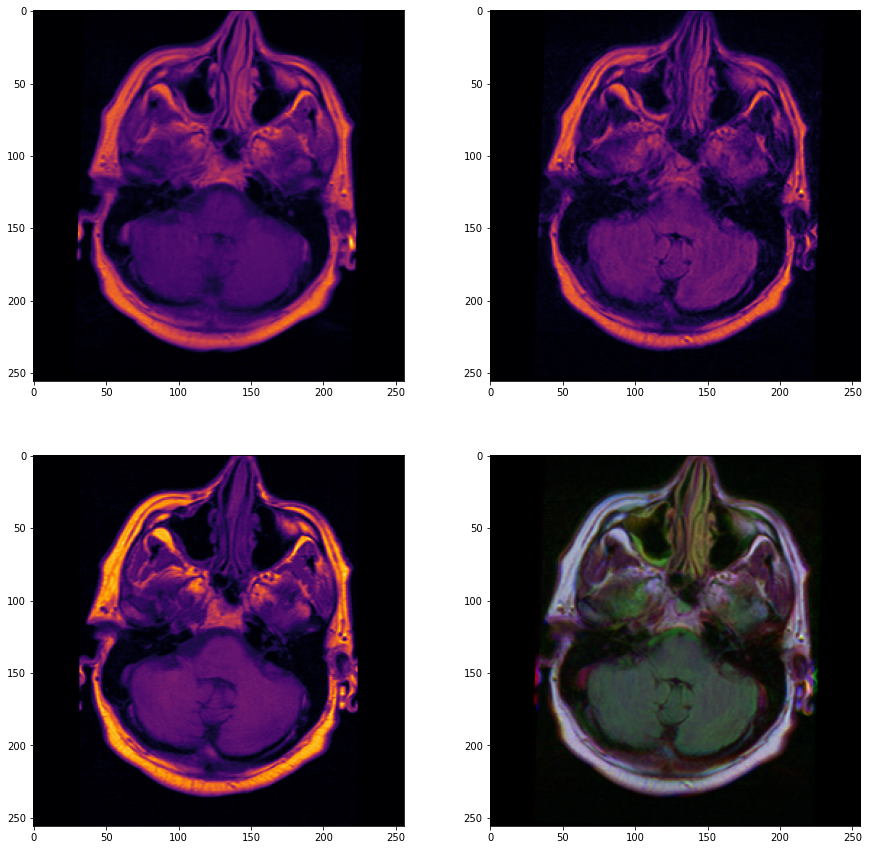

In [23]:
idx=np.random.choice(np.shape(x_rgb)[0])
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(x_rgb[idx][...,0], cmap='inferno')
plt.subplot(2,2,2)
plt.imshow(x_rgb[idx][...,1], cmap='inferno')
plt.subplot(2,2,3)
plt.imshow(x_rgb[idx][...,2], cmap='inferno')
plt.subplot(2,2,4)
plt.imshow(x_rgb[idx])

In [197]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='densenet201']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                           1
run_n                                                                0
network                                                    densenet201
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                              50
total_parameters                                              26378577
time                                                           3413.25
augm                                                              none
jaccard_distances                                           0.00329982
acc                                                           0.997469
sensitivity                                                   0.891923
specificity                                                   0.998744
FPR                                                         0.00125599
dice_c

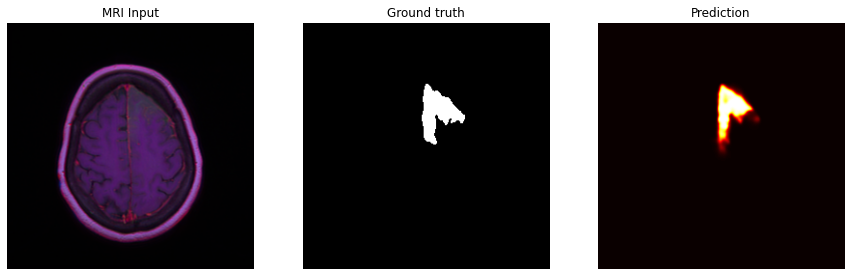

In [199]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_densenet201_results.svg')

In [201]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='inceptionresnetv2']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

...
tumor_type                                                           1
run_n                                                                0
network                                              inceptionresnetv2
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                              50
total_parameters                                              62061553
time                                                           3682.73
augm                                                              none
jaccard_distances                                           0.00261315
acc                                                           0.998088
sensitivity                                                   0.903073
specificity                                                   0.999087
FPR                                                        0.000913382
di

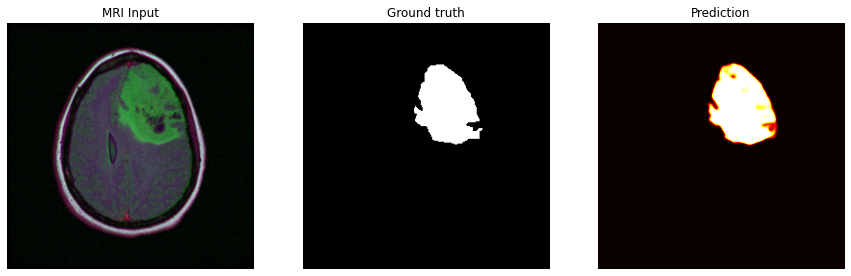

In [208]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_inceptionresnetv2_results.svg')

In [209]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='mobileNet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                           1
run_n                                                                0
network                                                      mobileNet
optimizer                                                         Adam
loss                                               binary_crossentropy
epochs                                                              50
total_parameters                                               8336337
time                                                              1097
augm                                                              none
jaccard_distances                                           0.00270047
acc                                                           0.998037
sensitivity                                                   0.916288
specificity                                                   0.998854
FPR                                                         0.00114638
dice_c

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


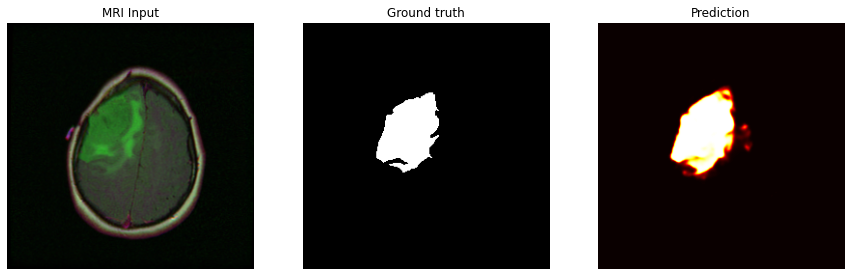

In [210]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_mobileNet_results.svg')

In [211]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='linknet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                       1
run_n                                                            0
network                                                    linknet
optimizer                                                     Adam
loss                                                  tversky_loss
epochs                                                          50
total_parameters                                          33700449
time                                                        2666.5
augm                                                          none
jaccard_distances                                       0.00232875
acc                                                       0.997655
sensitivity                                               0.894999
specificity                                               0.998739
FPR                                                     0.00126082
dice_coef                                                 0.88

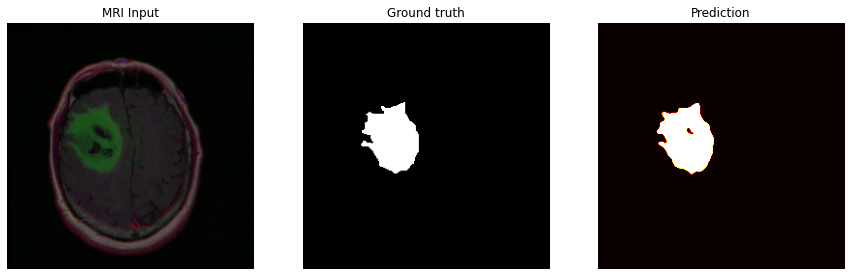

In [212]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_linknet_results.svg')

In [213]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='unet_cus']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                           1
run_n                                                                0
network                                                       unet_cus
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                              50
total_parameters                                               1945521
time                                                           1040.93
augm                                                              none
jaccard_distances                                           0.00302032
acc                                                           0.997602
sensitivity                                                   0.830323
specificity                                                   0.999372
FPR                                                        0.000628352
dice_c

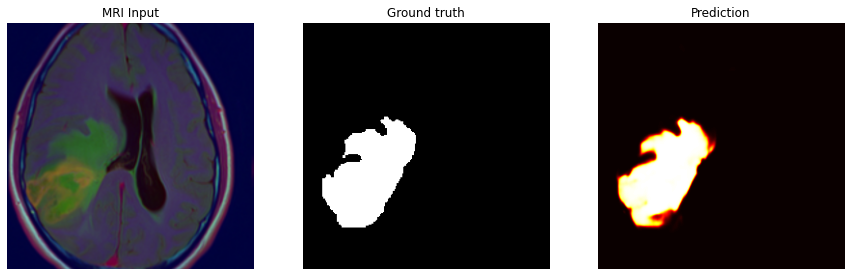

In [215]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_unet_cus_results.svg')

In [216]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='unetVgg16']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                           1
run_n                                                                0
network                                                      unetVgg16
optimizer                                                         Adam
loss                                        weighted_cross_entropyloss
epochs                                                              50
total_parameters                                              23752273
time                                                           2447.71
augm                                                              none
jaccard_distances                                           0.00298704
acc                                                           0.997413
sensitivity                                                   0.774406
specificity                                                   0.999537
FPR                                                        0.000463367
dice_c

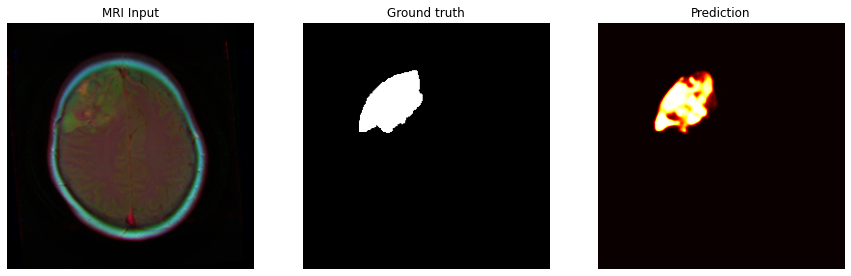

In [221]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_unetVgg16_results.svg')

In [25]:
from tf_semantic_segmentation import models

In [34]:
indx=np.random.choice(np.shape(x_rgb)[0], np.shape(x_rgb)[0], replace=False)
try:
  del model
except:
  print('...')
dafra=dfA.loc[dfA['network']=='multiresunet']
ind=np.where(dafra['dice_coef']==np.max(dafra['dice_coef']))[0][0]
print(dafra.iloc[ind])
dice=dfA.iloc[ind]['dice_coef']
model=read_model(dafra.iloc[ind]['network'])
model.load_weights(path_a+dafra.iloc[ind]['result_mat'][:-6]+'w.h5')
y_hat=model.predict(x_rgb[indx][:20])

tumor_type                                                           1
run_n                                                                0
network                                                   multiresunet
optimizer                                                         Adam
loss                                                    dice_coef_loss
epochs                                                              50
total_parameters                                               7262504
time                                                           4813.89
augm                                                              none
jaccard_distances                                           0.00500052
acc                                                           0.995916
sensitivity                                                   0.790686
specificity                                                   0.998128
FPR                                                         0.00187176
dice_c

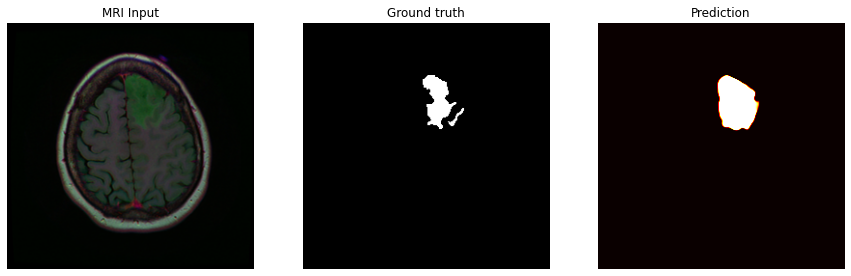

In [53]:
indi=np.random.choice(np.shape(y_hat)[0])
three_plot(x_rgb[indx][:20][indi], y_hat[indi,:,:,0], y_rgb[indx][:20][indi,:,:,0], dice, 'Andres_multiresunet_results.svg')